### NLP Project - Hate Speech Detection

In [1]:
## system imports ##
import os
import re
import copy

## externel imports ##
import nltk
import torch 
import torchvision
import numpy as np 
import pandas as pd
import torch.nn as nn
from sklearn import metrics
import matplotlib.pyplot as plt
import gensim.downloader as api
from torch.nn import functional as F
from sklearn.metrics import auc, roc_curve
import torchvision.transforms as transforms
from sklearn.linear_model import LogisticRegression

## project imports ##
from src.data_utils import gen_data, gen_bert_data, plot_graphs
from src.training import train_model, train_bert_model
from src.models import BiLSTM, AttentionModel

## global settings ##
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Data Preprocessing

In [2]:
hate_df = pd.read_csv("labeled_data.csv")
df = pd.DataFrame()
df['headline'] = hate_df.tweet.apply(lambda x: x.lower())
df['headline']=df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df['is_hate'] = hate_df['class'].apply(lambda x: 0 if x==2 else 1)
df.groupby('is_hate').count()

,headline
is_hate,
0,4163
1,20620


In [3]:
word2vec_model_dict = dict()
word2vec_model_dict['glove-twitter-100'] = api.load('glove-twitter-100')
curr_word2vec_model = word2vec_model_dict["glove-twitter-100"]
word2vec_model_size = len(curr_word2vec_model['unk'])
X_train, y_train, X_val, y_val, X_test, y_test, model_sentence_length  = gen_data(df, curr_word2vec_model)

I0906 22:43:52.024279 25880 utils_any2vec.py:341] loading projection weights from C:\Users\Alon/gensim-data\glove-twitter-100\glove-twitter-100.gz
I0906 22:45:35.347476 25880 utils_any2vec.py:405] loaded (1193514, 100) matrix from C:\Users\Alon/gensim-data\glove-twitter-100\glove-twitter-100.gz


### Logistic Regression Baseline

In [4]:
X_train_flat = X_train.reshape(-1, model_sentence_length*(word2vec_model_size))
X_val_flat = X_val.reshape(-1, model_sentence_length*(word2vec_model_size))
X_test_flat = X_test.reshape(-1, model_sentence_length*(word2vec_model_size))
log_reg = LogisticRegression()
log_reg.fit(X_train_flat, y_train)

print('LR Accuracy on training set: {:.3f}'.format(log_reg.score(X_train_flat, y_train)))
print('LR Accuracy on validation set: {:.3f}'.format(log_reg.score(X_val_flat, y_val)))

y_LR_test = log_reg.predict(X_test_flat)

C:\Users\Alon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy on training set: 0.967
LR Accuracy on validation set: 0.911


### Bidirectional LSTM

In [5]:
sequence_length = model_sentence_length
input_size = word2vec_model_size
hidden_size = input_size
num_layers = 2
num_classes = 2
batch_size = 64
num_epochs = 8
learning_rate = 0.005
lstm_dropout = 0.1

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data_loader = {"train" : train_loader, "test" : test_loader, "val" : val_loader}

lstm_model = BiLSTM(input_size, hidden_size, num_layers, num_classes, lstm_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [6]:
lstm_model = train_model(lstm_model, criterion, num_epochs, data_loader, optimizer, input_size, sequence_length)

-*-*-*-*-*-*-*-*-*-*
Epoch 1/8
train Loss: 0.2254  |  Acc: 0.9048 
val Loss: 0.0395  |  Acc: 0.9443 
-*-*-*-*-*-*-*-*-*-*
Epoch 2/8
train Loss: 0.1676  |  Acc: 0.9406 
val Loss: 0.0430  |  Acc: 0.9524 
-*-*-*-*-*-*-*-*-*-*
Epoch 3/8
train Loss: 0.1030  |  Acc: 0.9480 
val Loss: 0.0234  |  Acc: 0.9532 
-*-*-*-*-*-*-*-*-*-*
Epoch 4/8
train Loss: 0.1059  |  Acc: 0.9510 
val Loss: 0.0205  |  Acc: 0.9528 
-*-*-*-*-*-*-*-*-*-*
Epoch 5/8
train Loss: 0.0970  |  Acc: 0.9515 
val Loss: 0.0199  |  Acc: 0.9528 
-*-*-*-*-*-*-*-*-*-*
Epoch 6/8
train Loss: 0.2591  |  Acc: 0.9513 
val Loss: 0.0199  |  Acc: 0.9532 
-*-*-*-*-*-*-*-*-*-*
Epoch 7/8
train Loss: 0.0844  |  Acc: 0.9517 
val Loss: 0.0199  |  Acc: 0.9532 
-*-*-*-*-*-*-*-*-*-*
Epoch 8/8
train Loss: 0.0222  |  Acc: 0.9517 
val Loss: 0.0199  |  Acc: 0.9536 


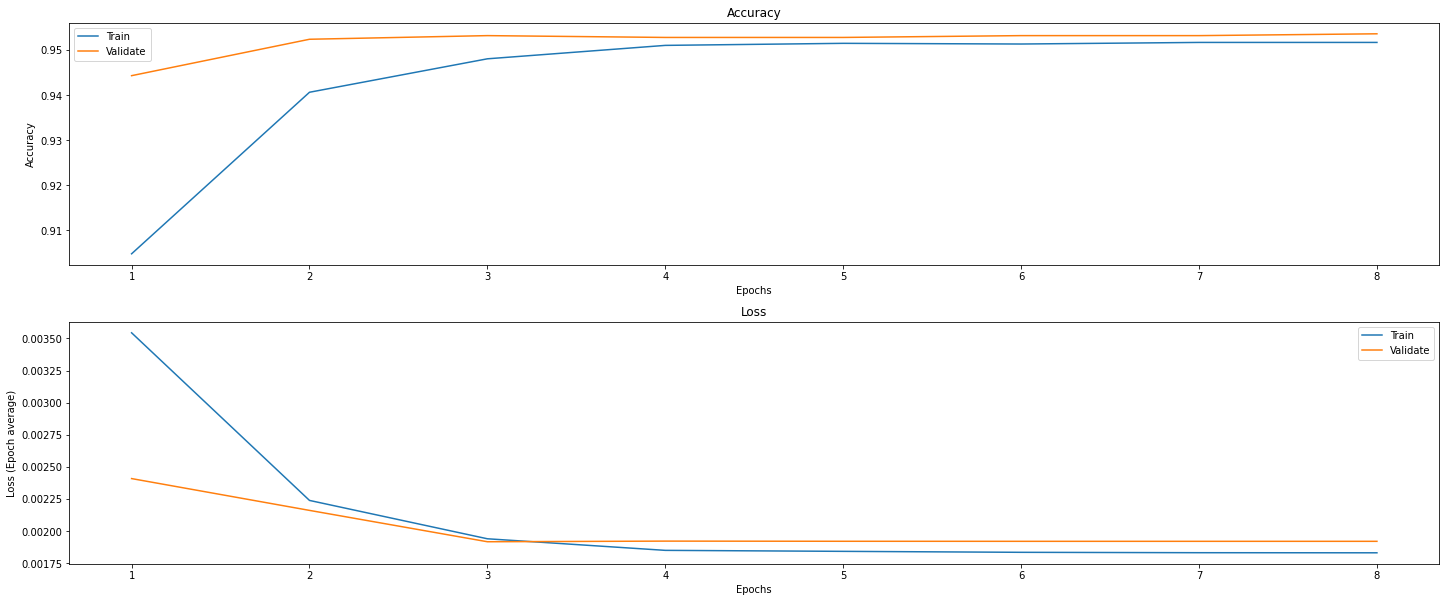

In [7]:
plot_graphs(lstm_model)

### Attention

In [8]:
sequence_length = model_sentence_length 
input_size = word2vec_model_size  
hidden_size = input_size    
num_layers = 2
num_classes = 2
batch_size = 64
num_epochs = 8
learning_rate = 0.005
lstm_dropout = 0.1 
alpha_dropout = 0.3

att_model = AttentionModel(input_size, hidden_size, num_layers, num_classes, lstm_dropout, 
                       sequence_length, alpha_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(att_model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [9]:
att_model = train_model(att_model, criterion, num_epochs, data_loader, optimizer, input_size, sequence_length)

-*-*-*-*-*-*-*-*-*-*
Epoch 1/8
train Loss: 0.1030  |  Acc: 0.9332 
val Loss: 0.0403  |  Acc: 0.9520 
-*-*-*-*-*-*-*-*-*-*
Epoch 2/8
train Loss: 0.0406  |  Acc: 0.9496 
val Loss: 0.0346  |  Acc: 0.9492 
-*-*-*-*-*-*-*-*-*-*
Epoch 3/8
train Loss: 0.1896  |  Acc: 0.9566 
val Loss: 0.0215  |  Acc: 0.9592 
-*-*-*-*-*-*-*-*-*-*
Epoch 4/8
train Loss: 0.0683  |  Acc: 0.9594 
val Loss: 0.0177  |  Acc: 0.9592 
-*-*-*-*-*-*-*-*-*-*
Epoch 5/8
train Loss: 0.1118  |  Acc: 0.9604 
val Loss: 0.0166  |  Acc: 0.9596 
-*-*-*-*-*-*-*-*-*-*
Epoch 6/8
train Loss: 0.0616  |  Acc: 0.9597 
val Loss: 0.0165  |  Acc: 0.9596 
-*-*-*-*-*-*-*-*-*-*
Epoch 7/8
train Loss: 0.0345  |  Acc: 0.9599 
val Loss: 0.0165  |  Acc: 0.9596 
-*-*-*-*-*-*-*-*-*-*
Epoch 8/8
train Loss: 0.0544  |  Acc: 0.9610 
val Loss: 0.0165  |  Acc: 0.9596 


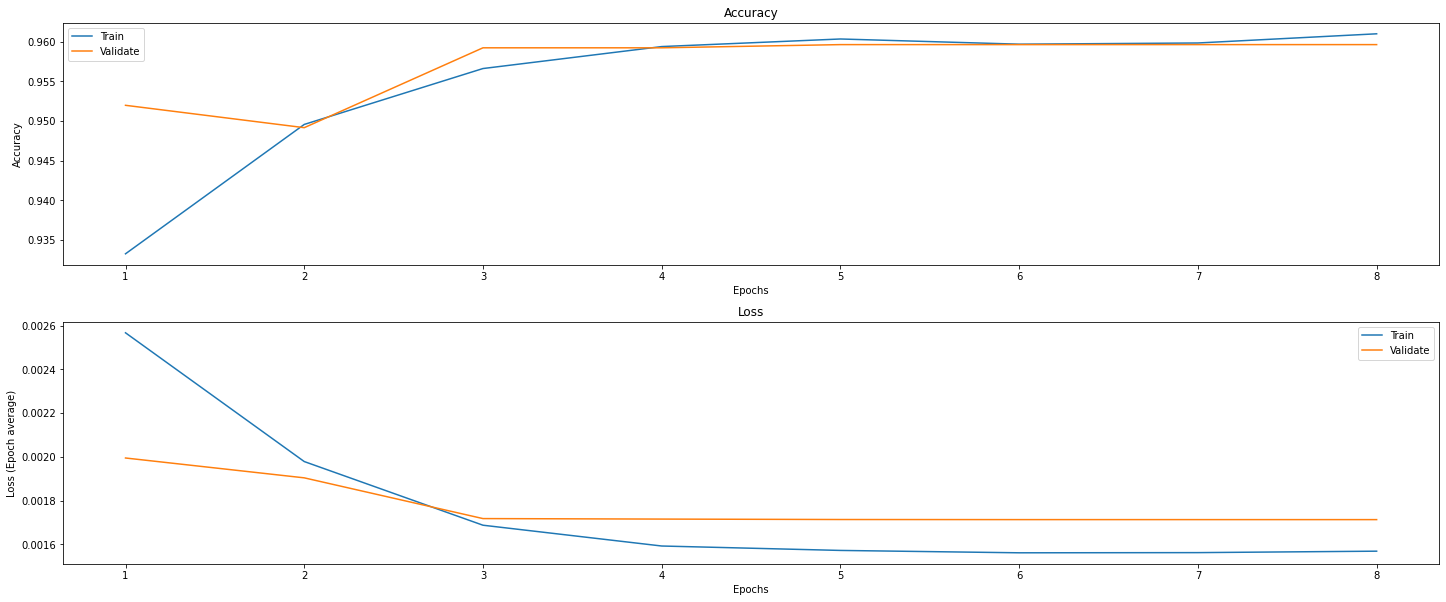

In [10]:
plot_graphs(att_model)

### BERT

In [15]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer
from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_dataloader, validation_dataloader, test_dataloader = gen_bert_data(df, tokenizer)

C:\Users\Alon\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


19,826 training samples
2,478 validation samples
Original:   rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out
Token IDs: tensor([  101, 19387,  9815, 19454, 21818,  2135,  2004,  1037,  2450,  2017,
         5807,  2102, 17612,  2055,  9344,  2039,  2115,  2160, 23713,  2004,
         1037,  2158,  2017,  2323,  2467,  2202,  1996, 11669,  2041,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)
bert.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(bert.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [18]:
bert, training_stats = train_bert_model(bert, train_dataloader, validation_dataloader, epochs, optimizer, scheduler)


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,240.    Elapsed: 0:00:15.
  Batch    80  of  1,240.    Elapsed: 0:00:29.
  Batch   120  of  1,240.    Elapsed: 0:00:44.
  Batch   160  of  1,240.    Elapsed: 0:00:59.
  Batch   200  of  1,240.    Elapsed: 0:01:14.
  Batch   240  of  1,240.    Elapsed: 0:01:29.
  Batch   280  of  1,240.    Elapsed: 0:01:43.
  Batch   320  of  1,240.    Elapsed: 0:01:58.
  Batch   360  of  1,240.    Elapsed: 0:02:13.
  Batch   400  of  1,240.    Elapsed: 0:02:27.
  Batch   440  of  1,240.    Elapsed: 0:02:42.
  Batch   480  of  1,240.    Elapsed: 0:02:55.
  Batch   520  of  1,240.    Elapsed: 0:03:09.
  Batch   560  of  1,240.    Elapsed: 0:03:23.
  Batch   600  of  1,240.    Elapsed: 0:03:37.
  Batch   640  of  1,240.    Elapsed: 0:03:51.
  Batch   680  of  1,240.    Elapsed: 0:04:05.
  Batch   720  of  1,240.    Elapsed: 0:04:19.
  Batch   760  of  1,240.    Elapsed: 0:04:34.
  Batch   800  of  1,240.    Elapsed: 0:04:48.
  Batch   840  of

In [19]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.15,0.13,0.96,0:07:25,0:00:16
2,0.09,0.14,0.96,0:07:22,0:00:15


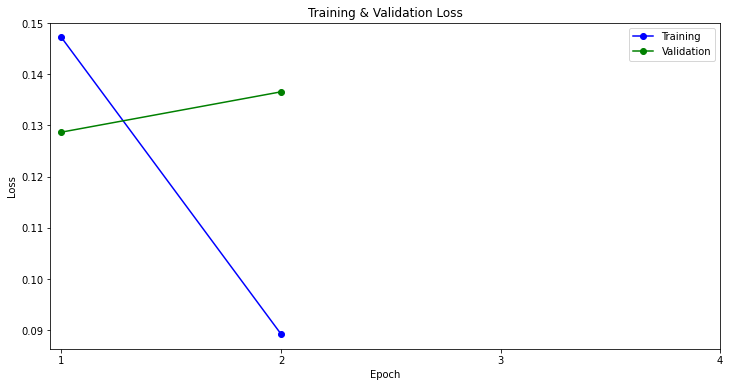

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [21]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dataloader)))

bert.eval()
predictions_bert , true_labels_bert = [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = bert(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions_bert.append(logits)
    true_labels_bert.append(label_ids)
print('DONE')

Predicting labels for 155 test sentences...
DONE


In [22]:
flat_predictions_bert = np.concatenate(predictions_bert, axis=0)
flat_predictions_bert = np.argmax(flat_predictions_bert, axis=1).flatten()

### Albert

In [23]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
train_dataloader, validation_dataloader, test_dataloader = gen_bert_data(df, tokenizer)

C:\Users\Alon\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


19,826 training samples
2,478 validation samples
Original:   rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out
Token IDs: tensor([    2,    13,  5256, 10473,   656,  4583,   102,    28,    21,   524,
           42, 18249, 15310,    88,  9724,    71,   154,   191, 14308,    28,
           21,   169,    42,   378,   550,   247,    14, 10744,    70,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

In [24]:
albert = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", 
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

optimizer = AdamW(albert.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
albert.cuda();

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [25]:
albert, training_stats = train_bert_model(albert, train_dataloader, validation_dataloader, epochs, optimizer, scheduler)


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,240.    Elapsed: 0:00:14.
  Batch    80  of  1,240.    Elapsed: 0:00:27.
  Batch   120  of  1,240.    Elapsed: 0:00:41.
  Batch   160  of  1,240.    Elapsed: 0:00:56.
  Batch   200  of  1,240.    Elapsed: 0:01:10.
  Batch   240  of  1,240.    Elapsed: 0:01:25.
  Batch   280  of  1,240.    Elapsed: 0:01:40.
  Batch   320  of  1,240.    Elapsed: 0:01:53.
  Batch   360  of  1,240.    Elapsed: 0:02:07.
  Batch   400  of  1,240.    Elapsed: 0:02:21.
  Batch   440  of  1,240.    Elapsed: 0:02:36.
  Batch   480  of  1,240.    Elapsed: 0:02:51.
  Batch   520  of  1,240.    Elapsed: 0:03:05.
  Batch   560  of  1,240.    Elapsed: 0:03:20.
  Batch   600  of  1,240.    Elapsed: 0:03:34.
  Batch   640  of  1,240.    Elapsed: 0:03:48.
  Batch   680  of  1,240.    Elapsed: 0:04:03.
  Batch   720  of  1,240.    Elapsed: 0:04:17.
  Batch   760  of  1,240.    Elapsed: 0:04:32.
  Batch   800  of  1,240.    Elapsed: 0:04:46.
  Batch   840  of

In [26]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dataloader)))

albert.eval()
predictions_albert , true_labels_albert = [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = bert(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions_albert.append(logits)
    true_labels_albert.append(label_ids)
print('DONE')

Predicting labels for 155 test sentences...
DONE


In [27]:
flat_predictions_albert = np.concatenate(predictions_albert, axis=0)
flat_predictions_albert = np.argmax(flat_predictions_albert, axis=1).flatten()

## Results Summary

In [28]:
# bert
fpr_BERT, tpr_BERT, thresholds_BERT = roc_curve(np.concatenate(true_labels_bert), flat_predictions_bert)
auc_BERT = metrics.auc(fpr_BERT, tpr_BERT)

# albert
fpr_ALBERT, tpr_ALBERT, thresholds_ALBERT = roc_curve(np.concatenate(true_labels_albert), flat_predictions_albert)
auc_ALBERT = metrics.auc(fpr_ALBERT, tpr_ALBERT)

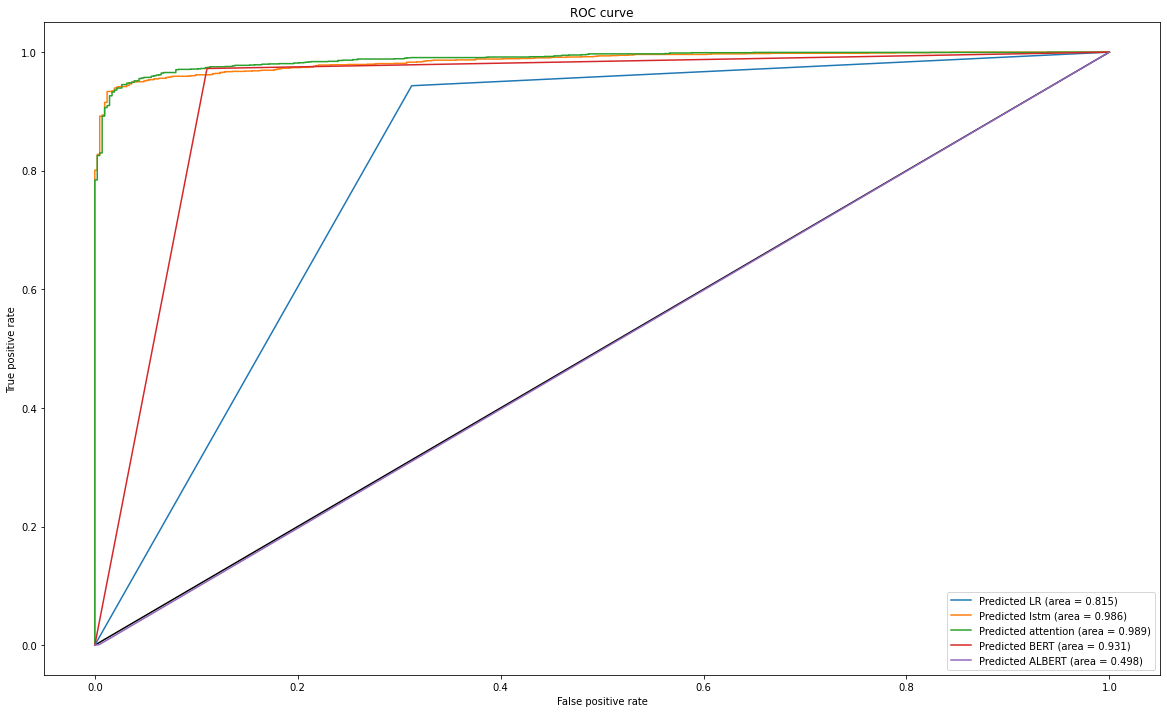

In [30]:
# LR 
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_LR_test)
auc_LR = metrics.auc(fpr_LR, tpr_LR)

# LSTM  
res_lstm = lstm_model(torch.from_numpy(X_test).float().to(device)).to('cpu').detach().numpy()
y_test_lstm = res_lstm[:, 1]

fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_test_lstm)
auc_lstm = metrics.auc(fpr_lstm, tpr_lstm) 

# attention 
res_att = att_model(torch.from_numpy(X_test).float().to(device)).to('cpu').detach().numpy()
y_test_att = res_att[:, 1]

fpr_att, tpr_att, thresholds_att = roc_curve(y_test, y_test_att)
auc_att = metrics.auc(fpr_att, tpr_att) 

plt.figure(1, figsize=(20,12))
plt.plot([0, 1], [0, 1], 'black')
plt.plot(fpr_LR, tpr_LR, label='Predicted LR (area = {:.3f})'.format(auc_LR))
plt.plot(fpr_lstm, tpr_lstm, label='Predicted lstm (area = {:.3f})'.format(auc_lstm))
plt.plot(fpr_att, tpr_att, label='Predicted attention (area = {:.3f})'.format(auc_att))
plt.plot(fpr_BERT, tpr_BERT, label='Predicted BERT (area = {:.3f})'.format(auc_BERT))
plt.plot(fpr_ALBERT, tpr_ALBERT, label='Predicted ALBERT (area = {:.3f})'.format(auc_ALBERT))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Hyper Parameter Search

In [31]:
import itertools

learning_rates = [1e-3, 2e-3]  # refined after some trials...
dropouts = [0.3, 0.5] 
weight_decays = [1e-5, 1e-6]

results = {}
best_val = -1   
best_stats = -1   

best_net = None 
for learning_rate, dropout, weight_decay in itertools.product(learning_rates, dropouts, weight_decays):
    print("Training model with learning_rate={}, dropout={}, weight_decay={}".format(learning_rate, dropout, weight_decay))
    learning_rate = learning_rate
    lstm_dropout = dropout
    alpha_dropout = dropout

    attention_model = AttentionModel(input_size, hidden_size, num_layers, num_classes, lstm_dropout, 
                       sequence_length, alpha_dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    curr_attention_model = train_model(attention_model, criterion, num_epochs, data_loader, optimizer,
                                     input_size, sequence_length, verbose=False)
    training_accuracy = curr_attention_model.train_acc[-1]
    validation_accuracy = curr_attention_model.best_val_acc
    results[(learning_rate, dropout, weight_decay)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_model = curr_attention_model
        best_val = validation_accuracy

Training model with learning_rate=0.001, dropout=0.3, weight_decay=1e-05
Training model with learning_rate=0.001, dropout=0.3, weight_decay=1e-06
Training model with learning_rate=0.001, dropout=0.5, weight_decay=1e-05
Training model with learning_rate=0.001, dropout=0.5, weight_decay=1e-06
Training model with learning_rate=0.002, dropout=0.3, weight_decay=1e-05
Training model with learning_rate=0.002, dropout=0.3, weight_decay=1e-06
Training model with learning_rate=0.002, dropout=0.5, weight_decay=1e-05
Training model with learning_rate=0.002, dropout=0.5, weight_decay=1e-06


In [32]:
for learn_rate, dropout, weight_dec in sorted(results):
    train_accuracy, val_accuracy = results[(learn_rate, dropout, weight_dec)]
    print ('lr {:.3f} dropout {:.1f} weight_dec {:.6f} train accuracy: {:.2f} val accuracy: {:.6f} '.format(
                learn_rate, dropout, weight_dec, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during validation: %f' % best_val)

lr 0.001 dropout 0.3 weight_dec 0.000001 train accuracy: 0.96 val accuracy: 0.954399 
lr 0.001 dropout 0.3 weight_dec 0.000010 train accuracy: 0.96 val accuracy: 0.955609 
lr 0.001 dropout 0.5 weight_dec 0.000001 train accuracy: 0.95 val accuracy: 0.954399 
lr 0.001 dropout 0.5 weight_dec 0.000010 train accuracy: 0.96 val accuracy: 0.956416 
lr 0.002 dropout 0.3 weight_dec 0.000001 train accuracy: 0.96 val accuracy: 0.958838 
lr 0.002 dropout 0.3 weight_dec 0.000010 train accuracy: 0.96 val accuracy: 0.960048 
lr 0.002 dropout 0.5 weight_dec 0.000001 train accuracy: 0.96 val accuracy: 0.961663 
lr 0.002 dropout 0.5 weight_dec 0.000010 train accuracy: 0.96 val accuracy: 0.959241 
best validation accuracy achieved during validation: 0.961663


# Model Accuracy by Sentence Length

In [33]:
# Create data with POS tagging and with lengths of sentences in each y
X_train_pos, y_train_pos, X_val_pos, y_val_pos, X_test_pos, y_test_pos, sequence_length  = gen_data(df, curr_word2vec_model, True, True)
y_train_pos_, y_val_pos_, y_test_pos_ = y_train_pos[:, 0], y_val_pos[:, 0], y_test_pos[:, 0] 

pos_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_pos).float(), torch.from_numpy(y_train_pos_).long())
pos_train_loader =  torch.utils.data.DataLoader(pos_train_dataset, batch_size=batch_size, shuffle=False)

pos_test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test_pos).float(), torch.from_numpy(y_test_pos_).long())
pos_test_loader =  torch.utils.data.DataLoader(pos_test_dataset, batch_size=batch_size, shuffle=False)

pos_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_pos).float(), torch.from_numpy(y_val_pos_).long())
pos_val_loader =  torch.utils.data.DataLoader(pos_val_dataset, batch_size=batch_size, shuffle=False)

pos_data_loader = {"train" : pos_train_loader, "test" : pos_test_loader, "val" : pos_val_loader}

In [34]:
sequence_length = model_sentence_length
input_size_pos =  word2vec_model_size + 1
hidden_size_pos = input_size_pos  
learning_rate = 5e-3
lstm_dropout = 0.5
alpha_dropout = 0.5
weight_dec = 1e-5
att_model = AttentionModel(input_size_pos, hidden_size_pos, num_layers, num_classes, lstm_dropout, 
                            sequence_length, alpha_dropout).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(att_model.parameters(), lr=learning_rate, weight_decay=weight_dec)
att_model = train_model(att_model, criterion, num_epochs, pos_data_loader, optimizer,
                                             input_size_pos, sequence_length, verbose=True)

res_pos = att_model(torch.from_numpy(X_val_pos).float().to(device)).to('cpu').detach().numpy()
y_val = np.argmax(res_pos, axis=1)

-*-*-*-*-*-*-*-*-*-*
Epoch 1/8
train Loss: 0.1016  |  Acc: 0.9315 
val Loss: 0.0583  |  Acc: 0.9508 
-*-*-*-*-*-*-*-*-*-*
Epoch 2/8
train Loss: 0.1152  |  Acc: 0.9500 
val Loss: 0.0501  |  Acc: 0.9487 
-*-*-*-*-*-*-*-*-*-*
Epoch 3/8
train Loss: 0.0493  |  Acc: 0.9590 
val Loss: 0.0156  |  Acc: 0.9605 
-*-*-*-*-*-*-*-*-*-*
Epoch 4/8
train Loss: 0.0417  |  Acc: 0.9632 
val Loss: 0.0165  |  Acc: 0.9609 
-*-*-*-*-*-*-*-*-*-*
Epoch 5/8
train Loss: 0.0454  |  Acc: 0.9624 
val Loss: 0.0164  |  Acc: 0.9609 
-*-*-*-*-*-*-*-*-*-*
Epoch 6/8
train Loss: 0.0536  |  Acc: 0.9636 
val Loss: 0.0164  |  Acc: 0.9609 
-*-*-*-*-*-*-*-*-*-*
Epoch 7/8
train Loss: 0.0506  |  Acc: 0.9625 
val Loss: 0.0164  |  Acc: 0.9609 
-*-*-*-*-*-*-*-*-*-*
Epoch 8/8
train Loss: 0.0394  |  Acc: 0.9627 
val Loss: 0.0164  |  Acc: 0.9609 


In [35]:
# go over results and obtain a detailed results according to length bins
corr_5, total_5 = 0.0, 0.0
corr_10, total_10 = 0.0, 0.0
corr_15, total_15 = 0.0, 0.0
corr_big, total_big = 0.0, 0.0

for ii, _ in enumerate(y_test_pos_):
    curr_sentence_size =  y_val_pos[ii, 1]
    if max(y_val[ii], 0) == y_val_pos[ii, 0]:
        if curr_sentence_size<=5:
            corr_5+=1
        elif curr_sentence_size<=10:
            corr_10+=1
        elif curr_sentence_size<=15:
            corr_15+=1
        else:
            corr_big+=1
    if curr_sentence_size<=5:
        total_5+=1
    elif curr_sentence_size<=10:
        total_10+=1
    elif curr_sentence_size<=15:
        total_15+=1
    else:
        total_big+=1    
    
print("Accuracy of sentences of at most 5 words is {}".format(corr_5/total_5))
print("Accuracy of sentences of at most 10 words is {}".format(corr_10/total_10))
print("Accuracy of sentences of at most 15 words is {}".format(corr_15/total_15))
print("Accuracy of sentences bigger than 15 words is {}".format(corr_big/total_big))

Accuracy of sentences of at most 5 words is 0.9528301886792453
Accuracy of sentences of at most 10 words is 0.969551282051282
Accuracy of sentences of at most 15 words is 0.9694041867954911
Accuracy of sentences bigger than 15 words is 0.9520078354554359


In [36]:
sequence_length = model_sentence_length
input_size = word2vec_model_size + 1
hidden_size = input_size
num_layers = 2
num_classes = 2
batch_size = 64
num_epochs = 8
learning_rate = 0.005
lstm_dropout = 0.1

lstm_model = BiLSTM(input_size, hidden_size, num_layers, num_classes, lstm_dropout).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
lstm_model = train_model(lstm_model, criterion, num_epochs, pos_data_loader, optimizer, input_size, sequence_length)
res_lstm = lstm_model(torch.from_numpy(X_val_pos).float().to(device)).to('cpu').detach().numpy()
y_val = np.argmax(res_lstm, axis=1)

# go over results and obtain a detailed results according to length bins
corr_5, total_5 = 0.0, 0.0
corr_10, total_10 = 0.0, 0.0
corr_15, total_15 = 0.0, 0.0
corr_big, total_big = 0.0, 0.0

for ii, _ in enumerate(y_test_pos_):
    curr_sentence_size =  y_val_pos[ii, 1]
    if max(y_val[ii], 0) == y_val_pos[ii, 0]:
        if curr_sentence_size<=5:
            corr_5+=1
        elif curr_sentence_size<=10:
            corr_10+=1
        elif curr_sentence_size<=15:
            corr_15+=1
        else:
            corr_big+=1
    if curr_sentence_size<=5:
        total_5+=1
    elif curr_sentence_size<=10:
        total_10+=1
    elif curr_sentence_size<=15:
        total_15+=1
    else:
        total_big+=1    
        
print("Accuracy of sentences of at most 5 words is {}".format(corr_5/total_5))
print("Accuracy of sentences of at most 10 words is {}".format(corr_10/total_10))
print("Accuracy of sentences of at most 15 words is {}".format(corr_15/total_15))
print("Accuracy of sentences bigger than 15 words is {}".format(corr_big/total_big))

-*-*-*-*-*-*-*-*-*-*
Epoch 1/8
train Loss: 0.1816  |  Acc: 0.8710 
val Loss: 0.0512  |  Acc: 0.9419 
-*-*-*-*-*-*-*-*-*-*
Epoch 2/8
train Loss: 0.0965  |  Acc: 0.9396 
val Loss: 0.0311  |  Acc: 0.9520 
-*-*-*-*-*-*-*-*-*-*
Epoch 3/8
train Loss: 0.0903  |  Acc: 0.9502 
val Loss: 0.0241  |  Acc: 0.9512 
-*-*-*-*-*-*-*-*-*-*
Epoch 4/8
train Loss: 0.0912  |  Acc: 0.9519 
val Loss: 0.0228  |  Acc: 0.9544 
-*-*-*-*-*-*-*-*-*-*
Epoch 5/8
train Loss: 0.0903  |  Acc: 0.9517 
val Loss: 0.0224  |  Acc: 0.9548 
-*-*-*-*-*-*-*-*-*-*
Epoch 6/8
train Loss: 0.0905  |  Acc: 0.9524 
val Loss: 0.0225  |  Acc: 0.9544 
-*-*-*-*-*-*-*-*-*-*
Epoch 7/8
train Loss: 0.0905  |  Acc: 0.9524 
val Loss: 0.0225  |  Acc: 0.9540 
-*-*-*-*-*-*-*-*-*-*
Epoch 8/8
train Loss: 0.0906  |  Acc: 0.9523 
val Loss: 0.0225  |  Acc: 0.9540 
Accuracy of sentences of at most 5 words is 0.9433962264150944
Accuracy of sentences of at most 10 words is 0.9519230769230769
Accuracy of sentences of at most 15 words is 0.9710144927536232
A